In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from __future__ import print_function
from scipy import signal

Variables:

    t_inter - period in microseconds at which microcontroller interrupt is called
    freq_samp = 1/(t_inter) - ADC sampling frequency
    n_samp_cos - number of samples of one cosine period in look up table
    lut - look up table with cosine values
    freq_cos = 1/(t_inter*n_samp_cos) - cosine sampling frequency
    n_coef - number of coefficients in filter array
    lp_coef - array of filter coefficients
    buf - last n_filt values from ADC
    n_total_samples - array size for in_array & lp_out
    in_array - array with simulated ADC values
    lp_out - array with filtered values

In [2]:
t_inter = 100
n_samp_cos = 10
freq_samp = 1.0/((t_inter*1e-6))
freq_cos = 1.0/((t_inter*1e-6)*n_samp_cos)
print('cosine freq =', freq_cos, 'Hz')
print('sampling freq =', freq_samp, 'Hz')

cosine freq = 1000.0 Hz
sampling freq = 10000.0 Hz


[ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699]


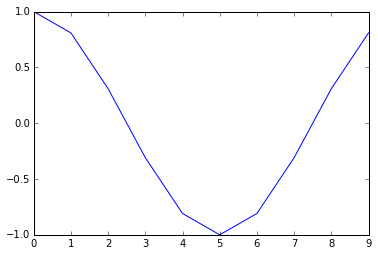

In [3]:
lut = np.zeros(n_samp_cos)
lut = np.cos(2.0*np.pi*np.arange(n_samp_cos)/n_samp_cos)
print(lut)
fig, ax = plt.subplots()
ax.plot(range(n_samp_cos), lut);

Calculate coefficients from [FIR Filter Design](http://www.arc.id.au/FilterDesign.html) for Kaiser-Bessel filter generator with the following parameters for a low pass filter: Fa = 0 Hz, Fb = 100 Hz, M(odd) length = 37, dF/2 is 503 Hz (given by calculator), Fs = 10 kHz, Att = 60 dB

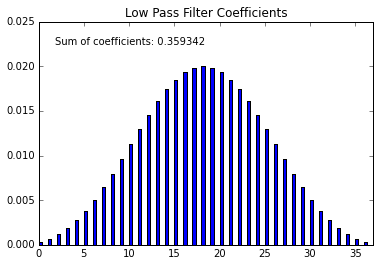

In [7]:
lp_coef = [0.000326, 0.000692, 0.001207, 0.001891, 0.002756, 
           0.003806, 0.005036, 0.006430, 0.007961, 0.009591, 
           0.011275, 0.012958, 0.014582, 0.016086, 0.017413, 
           0.018507, 0.019325, 0.019829, 0.020000, 0.019829, 
           0.019325, 0.018507, 0.017413, 0.016086, 0.014582, 
           0.012958, 0.011275, 0.009591, 0.007961, 0.006430, 
           0.005036, 0.003806, 0.002756, 0.001891, 0.001207, 0.000692, 0.000326]
n_coef = len(lp_coef)
buf = np.zeros(n_coef)
# plot filter coefficients
ind = np.arange(n_coef)
fig, ax = plt.subplots()
ax.bar(ind, lp_coef, 0.35)
ax.set_xlim(0,37)
temptext = 'Sum of coefficients: {}'.format(np.sum(lp_coef))
ax.text(0.05, 0.9, temptext, transform = ax.transAxes)
ax.set_title('Low Pass Filter Coefficients');

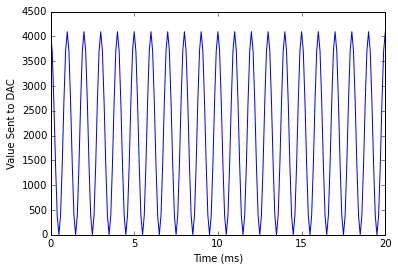

In [8]:
n_total_samples = 201
dac_output = np.zeros(n_total_samples)
time_dac_output = np.zeros(n_total_samples)
for i in range(n_total_samples):
    lut_index = np.mod(i,n_samp_cos)
    dac_output[i] = 4095 * 0.5*(1.0 + lut[lut_index])
    time_dac_output[i] = i*t_inter * 1e-3  #convert to msec from usec

fig, ax = plt.subplots()
ax.plot(time_dac_output, dac_output)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Value Sent to DAC');

In [9]:
def fir_basic(new_value, h, buf):
    '''Calculate FIR filtered value given filter coefficients, h, and delay line, buf
    
       inputs:
           new_value - latest sample
           h - array of filter coefficients
           buf - array containing previous sample values. Should be equal in length to h
       returns:
           new filtered value'''
    num_coef = len(h)
    buf[0] = new_value
    accum = 0
    for i in range(num_coef):
        accum += h[i] * buf[i]
    # shift values to right in z buffer
    for i in range(num_coef-2, -1, -1):
        buf[i+1] = buf[i]
    #print(z, '\n', h)
    return accum

def zero_buf(buf):
    buf = 0.0

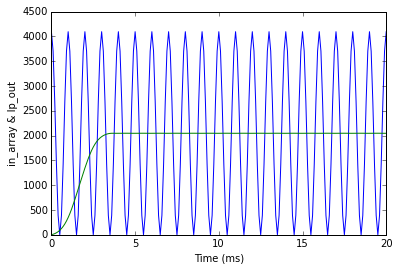

In [10]:
in_array = np.copy(dac_output)
#in_array += 3000
n_pts = len(in_array)
lp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    lp_out[i] = fir_basic(in_array[i], lp_coef, buf)
correction_factor = np.sum(lp_coef)   
lp_out /= correction_factor        # divide result by sum of coefficients to get actual DC value of cosine

fig, ax = plt.subplots()
ax.plot(time_dac_output, in_array)
ax.plot(time_dac_output, lp_out)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('in_array & lp_out');

Calculate coefficients from [FIR Filter Design](http://www.arc.id.au/FilterDesign.html) for Kaiser-Bessel filter generator with the following parameters for a bandpass filter: Fa = 950 Hz, Fb = 1050 Hz, M(odd) length = 37, dF/2 is 503 Hz (given by calculator), Fs = 10 kHz, Att = 60 dB

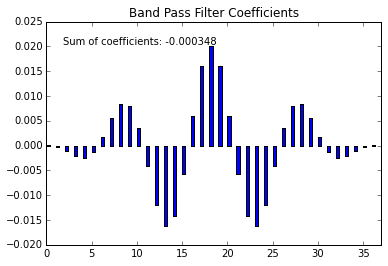

In [13]:
bp_coef = [0.000119, -0.000248, -0.001115, -0.002123, -0.002464, 
           -0.001282, 0.001674, 0.005529, 0.008370, 0.008080, 
           0.003597, -0.004103, -0.012010, -0.016287, -0.014199, 
           -0.005745, 0.005983, 0.016050, 0.020000, 0.016050, 
           0.005983, -0.005745, -0.014199, -0.016287, -0.012010, 
           -0.004103, 0.003597, 0.008080, 0.008370, 0.005529, 
           0.001674, -0.001282, -0.002464, -0.002123, -0.001115, -0.000248, 0.000119] 
if len(bp_coef) != len(lp_coef):
    print('LOW PASS & BAND PASS FILTERS ARE NOT THE SAME LENGTH')
# plot filter coefficients
ind = np.arange(n_coef)
fig, ax = plt.subplots()
ax.bar(ind, bp_coef, 0.35)
ax.set_xlim(0,37)
temptext = 'Sum of coefficients: {}'.format(np.sum(bp_coef))
ax.text(0.05, 0.9, temptext, transform = ax.transAxes)
ax.set_title('Band Pass Filter Coefficients');

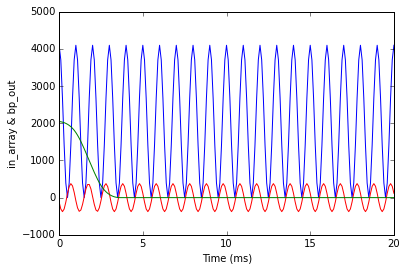

In [15]:
in_array = np.copy(dac_output)
#in_array += 3000
n_pts = len(in_array)
bp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    bp_out[i] = fir_basic(in_array[i], bp_coef, buf)
lp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    lp_out[i] = fir_basic(bp_out[i], lp_coef, buf)
correction_factor = np.sum(lp_coef)   # divide result by sum of coefficients to get actual DC value of cosine
lp_out /= correction_factor

fig, ax = plt.subplots()
ax.plot(time_dac_output, in_array)
ax.plot(time_dac_output, bp_out, 'r')
ax.plot(time_dac_output, lp_out, 'g')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('in_array & bp_out');

In [16]:
print(lp_out[150:160])

[-0.53682857 -0.49535109 -0.53682857 -0.64541803 -0.77964197 -0.88823143
 -0.92970891 -0.88823143 -0.77964197 -0.64541803]


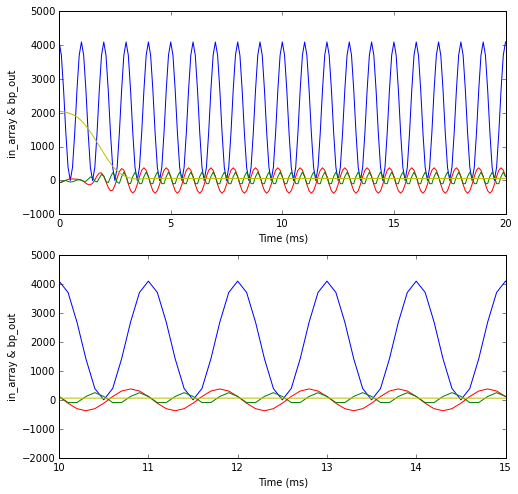

In [17]:
in_array = np.copy(dac_output)
n_pts = len(in_array)
bp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    bp_out[i] = fir_basic(in_array[i], bp_coef, buf)
# Multiply by cosine
cosmult_out = np.zeros(n_pts)
for i in range(n_pts):
    lut_index = np.mod(i,n_samp_cos)
    cosmult_out[i] = bp_out[i] * lut[lut_index]
lp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    lp_out[i] = fir_basic(cosmult_out[i], lp_coef, buf)
correction_factor = np.sum(lp_coef)   # divide result by sum of coefficients to get actual DC value of cosine
lp_out /= correction_factor


fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output, in_array)
ax.plot(time_dac_output, bp_out, 'r')
ax.plot(time_dac_output, cosmult_out, 'g')
ax.plot(time_dac_output, lp_out, 'y')
#ax.set_ylim(-5000, 5000)
#ax.set_xlim(40, 45)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('in_array & bp_out')
ax2.plot(time_dac_output, in_array)
ax2.plot(time_dac_output, bp_out, 'r')
ax2.plot(time_dac_output, cosmult_out, 'g')
ax2.plot(time_dac_output, lp_out, 'y')
ax2.set_ylim(-2000, 5000)
ax2.set_xlim(10, 15)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('in_array & bp_out');

In [18]:
print(lp_out[150:160])

[ 58.20036094  58.12908329  58.08498275  58.12879917  58.19990123
  58.20010682  58.12933741  58.08564805  58.12962153  58.20056653]


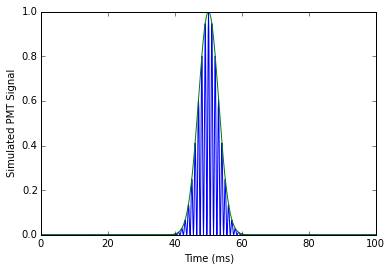

In [19]:
n_total_samples = 1001
time_interrupts = np.linspace(0, n_total_samples*t_inter*1e-3, num=n_total_samples)
pmt_signal = np.zeros(n_total_samples)
time_dac_output = np.zeros(n_total_samples)
modulation = signal.gaussian(n_total_samples, 30.0)
for i in range(n_total_samples):
    lut_index = np.mod(i,n_samp_cos)
    pmt_signal[i] = 0.5*(1.0 + lut[lut_index]) * modulation[i]

fig, ax = plt.subplots()
ax.plot(time_interrupts, pmt_signal)
ax.plot(time_interrupts, modulation)
ax.set_xlim(0,100)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Simulated PMT Signal');

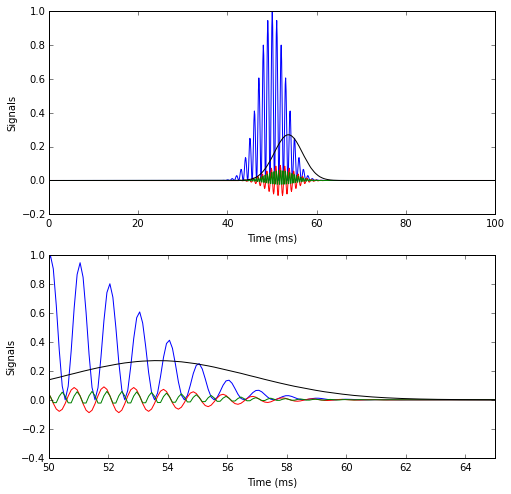

In [25]:
in_array = np.copy(pmt_signal)
n_pts = len(in_array)
bp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    bp_out[i] = fir_basic(in_array[i], bp_coef, buf)
# Multiply by cosine
cosmult_out = np.zeros(n_pts)
for i in range(n_pts):
    lut_index = np.mod(i,n_samp_cos)
    cosmult_out[i] = bp_out[i] * lut[lut_index]
lp_out = np.zeros(n_pts)
zero_buf(buf)
for i in range(n_pts):
    lp_out[i] = fir_basic(cosmult_out[i], lp_coef, buf)
correction_factor = np.sum(lp_coef)   # divide result by sum of coefficients to get actual DC value of cosine
lp_out /= correction_factor


fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_interrupts, in_array)
ax.plot(time_interrupts, bp_out, 'r')
ax.plot(time_interrupts, cosmult_out, 'g')
ax.plot(time_interrupts, 20*lp_out, 'k')
#ax.set_ylim(-5000, 5000)
ax.set_xlim(0, 100)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_interrupts, in_array)
ax2.plot(time_interrupts, bp_out, 'r')
ax2.plot(time_interrupts, cosmult_out, 'g')
ax2.plot(time_interrupts, 20*lp_out, 'k')
ax2.set_ylim(-0.4, 1)
ax2.set_xlim(50, 65)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Signals');

In [54]:
temparray = np.zeros(5)
temparray

array([ 0.,  0.,  0.,  0.,  0.])

In [55]:
def tempfunc(a):
    a[0] = 1.0
    a[2] = 3.0
tempfunc(temparray)
temparray

array([ 1.,  0.,  3.,  0.,  0.])